На входе алгоритма набор пар целочисленных координат точек от 0 до 500, а также для каждой точки размеры подписи к ней (два целых числа — ширина и высота рамки подписи) и некоторое подмножество возможных расположений подписи (см. картинки справа). Кодирование входных данных — на ваш выбор, но лучше согласовать друг с другом в Телеграме, чтобы удобно было обмениваться примерами входных данных.

На выходе — картинка с точками и неперекрывающимися метками (в частности, не вылезающими за пределы холста 500×500) либо указание, что такое расположение недостижимо.

Задачу можно решать

либо в постановке, когда для каждой точки задан выбор не более чем из двух вариантов расположения подписи, и написать самостоятельно 2-SAT решатель,

либо без ограничений на количество вариантов, и тогда допустимо воспользоваться сторонним SAT-решателем, указав, как Вы кодируете задачу.

In [98]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import networkx as nx

In [352]:
"0,0-point    10,10-size    0,0 2,0-two types of positions"

txt = "./bins.txt"
points = []
sizes = []
places = []
with open(txt, 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.strip('\n').split('\t')
        point, size, place = line.strip('\n').split('\t')
        x, y = point.split(',')
        w, h = size.split(",")
        p1, p2 = place.split(" ")
        p1x, p1y = p1.split(",")
        p2x, p2y = p2.split(",")
        
        points.append((int(x), int(y)))
        sizes.append((int(w), int(h)))        
        places.append([(int(p1x), int(p1y)), (int(p2x), int(p2y))])       

border = (500, 500) #width-hight

In [350]:
# debug ex-le
points = [(10, 10), (20, 20), (40, 5), (16, 16), (30, 40)]
sizes = [(5, 5), (16, 8), (15, 5), (3, 3), (5, 5)]
places = [[(0, 0), (5, 5)], [(8, 8), (0, 0)], [(0, 5), (15, 0)], [(0, 0), (3, 3)], [(0, 0), (5, 5)]]
border = (50, 50) #width-hight

In [353]:
class Frame:
    def __init__(self, lb_x, lb_y, rt_x, rt_y):
        self.lb_x = lb_x
        self.rt_x = rt_x
        self.lb_y = lb_y
        self.rt_y = rt_y
        
        self.border_lb_x = 0
        self.border_lb_y = 0
        self.border_rt_x = border[0]
        self.border_rt_y = border[1]
    
    def cross_other_frame(self, other):
        a = self.lb_x > other.rt_x 
        b = self.rt_x < other.lb_x
        c = self.rt_y < other.lb_y
        d = self.lb_y > other.rt_y
        return not(a or b or c or d)

    def cross_border(self):
        a = self.lb_x < self.border_lb_x
        b = self.lb_y < self.border_lb_y
        c = self.rt_x > self.border_rt_x
        d = self.rt_y > self.border_rt_y
        return a or b or c or d
    
    def draw(self, ax):
        frame = Rectangle(
            (self.lb_x, self.lb_y),
            self.rt_x - self.lb_x,
            self.rt_y - self.lb_y,
            edgecolor="blue",
            facecolor='none',
            lw=1)
        ax.add_patch(frame)

In [354]:
class Point:
    def __init__(self, point, size, places):
        self.x = point[0]
        self.y = point[1]
        self.frame1 = Frame(self.x-places[0][0], self.y-places[0][1], self.x-places[0][0]+size[0], self.y-places[0][1]+size[1])
        self.frame2 = Frame(self.x-places[1][0], self.y-places[1][1], self.x-places[1][0]+size[0], self.y-places[1][1]+size[1])
        self.choice = None
    
    def frame_cross(self, other):
        crosses = []
        if self.frame1.cross_other_frame(other.frame1):
            crosses.append((1, 1))
        if self.frame1.cross_other_frame(other.frame2):
            crosses.append((1, 2))
        if self.frame2.cross_other_frame(other.frame1):
            crosses.append((2, 1))
        if self.frame2.cross_other_frame(other.frame2):
            crosses.append((2, 2))
        
        return crosses

    def border_cross(self):
        crosses = []
        if self.frame1.cross_border():
            crosses.append(1)
        if self.frame2.cross_border():
            crosses.append(2)
        return crosses

    def draw(self, ax):
        ax.scatter(self.x, self.y, color='blue')
        if self.choice == 1:
            self.frame1.draw(ax)
        if self.choice == 2:
            self.frame2.draw(ax)

In [362]:
class PointFramePlace:
    def __init__(self, points, sizes, places):
        self.points = {}
        self.n = len(points)
        self.scc = {}
        self.scc = {}
        
        self.g = nx.DiGraph()
        for i in range(self.n):
            self.g.add_node(i + 1)
            self.g.add_node(i + 1 + self.n)
            self.points[i] = Point(points[i], sizes[i], places[i])

    def frame_cross(self):
        res = {}
        for i in range(self.n-1):
            for j in range(i+1, self.n):
                crosses = self.points[i].frame_cross(self.points[j])
                if crosses:
                    res[(i + 1, j + 1)] = crosses
        return res

    def border_cross(self):
        crosses = {}
        for i in range(self.n):
            crosses[i+1] = self.points[i].border_cross()
        return crosses

    def create_frame_edges(self, cross, points):
        for frame in cross:
            self.g.add_edge((2-frame[0])*(self.n)+points[0], (frame[1]-1)*(self.n)+points[1])
            self.g.add_edge((2-frame[1])*(self.n)+points[1], (frame[0]-1)*(self.n)+points[0])
    
    def create_self_edges(self, cross, point):
        for frame in cross:
            self.g.add_edge((frame-1)*self.n+point, ((2-frame)*self.n+point))
    
    def create_edges(self):
        frame_cross = self.frame_cross()
        border_cross = self.border_cross()

        for i in frame_cross:
            self.create_frame_edges(frame_cross[i], i)
        for i in border_cross:
            self.create_self_edges(border_cross[i], i)

    def find_strongly_connected_components(self):
        scc = list(nx.kosaraju_strongly_connected_components(self.g))
        for num_component in range(len(scc)):
            nodes = scc[num_component]
            for node in nodes:
                self.scc[node] = num_component
        return scc

    def check_solvable(self):
        for i in range(self.n):
            if self.scc[i+1] == self.scc[i+1+self.n]:
                return False
        return True
    
    def choices(self):
        for i in range(self.n):
            if self.scc[i+1] > self.scc[i+1+self.n]:
                self.points[i].choice = 1
            else:
                self.points[i].choice = 2

    def calc(self):
        self.create_edges()
        scc = self.find_strongly_connected_components()
        solvable = self.check_solvable()
        if not solvable:
            print("Such point-frame placement cannot be solved!")
        else:
#             gc = nx.condensation(self.g, scc)
#             top_sort = nx.topological_sort(gc)
#             print(list(top_sort))
#             for i in range(len(list(top_sort))):
#                 node = top_sort[i]
#                 print(i, node)
#                 self.scc[node] = i     
            self.choices()
        return solvable

    def draw(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        for i in self.points:
            self.points[i].draw(ax)
        plt.show()
        fig.savefig('result.svg')

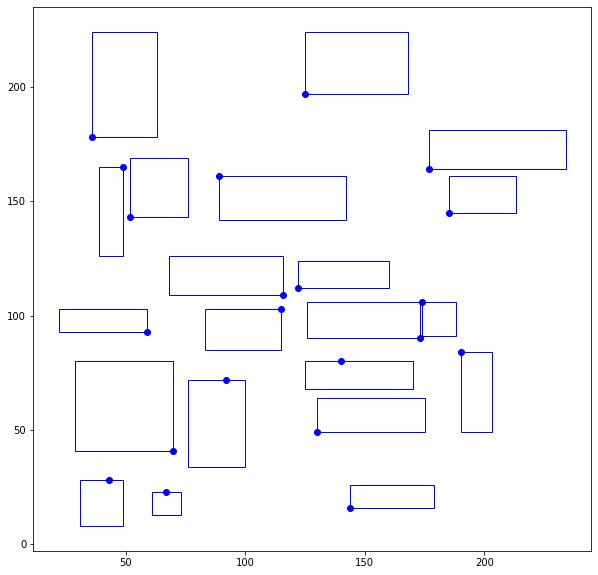

In [363]:
pfp = PointFramePlace(points, sizes, places)
solved = pfp.calc()
if solved:
    pfp.draw()